In [1]:
import sys
sys.path.insert(0,'..')
from llmdh import *
sys.path.insert(0,'/Users/ryan/github/prosodic')
from prosodic import Word
import math
import string

In [9]:
x=LLM.generate_openai('Write a poem with 5 stanzas that does NOT rhyme.')#, model_kwargs=dict(logprobs=True))
print(x)

In the silence of the night,
I lie awake and ponder
The complexities of life,
The fleeting moments that wander

Through my mind, like ghosts
From a distant past
Haunting my every thought,
Leaving me lost

In a sea of confusion,
Searching for meaning
In a world that is filled
With chaos and scheming

But amidst the darkness,
There is a glimmer of hope
A beacon of light
Guiding me to cope

With the trials and tribulations
That come my way
I find solace in the stillness
Of the night and I pray.


In [167]:
@classmethod
def generate_openai_logprobs(
    cls,
    user_prompt,
    *args,
    model=LLM_DEFAULT_MODEL_OPENAI,
    verbose=False,
    max_tokens=MAX_TOKENS,
    name=None,
    temp=1.0,
    **kwargs,
):
    res = []
    with logmap(f"prompting LLM model {model}", announce=verbose) as lm:
        prompt = cls.format_prompt(user_prompt, *args, model=model, **kwargs)
        # if verbose: lm.log(f'PROMPT: {prompt}')
        try:
            chat_completion = cls.openai_api().chat.completions.create(
                messages=prompt, 
                model=model, 
                max_tokens=max_tokens,
                logprobs=True,
                top_logprobs=5,
                temperature=temp,
            )
            choices = chat_completion.choices
            word_probs = choices[0].logprobs.content
            line_i=0
            for i,word_d in enumerate(word_probs):
                chosentoken = word_d.token
                print(chosentoken,end='',flush=True)
                line_i+=chosentoken.count('\n')
                for ii,prob_d in enumerate(word_d.top_logprobs):
                    odx={
                        'line_i':line_i+1,
                        'token_i':i+1,
                        'token_str':chosentoken, 
                        'choice_i':ii+1, 
                        'choice_str':prob_d.token,
                        'logprob':prob_d.logprob,
                        'prob':math.exp(prob_d.logprob) * 100
                    }
                    res.append(odx)
        except Exception as e:
            logger.error(e)
        return res
        

LLM.generate_openai_logprobs = generate_openai_logprobs

In [168]:
def generate_poem_logprobs(prompt='Write a poem with 4 lines.', **kwargs):
    res = LLM.generate_openai_logprobs(prompt, **kwargs)
    df=pd.DataFrame(res)
    d,d_r={},{}
    for g,gdf in df[df.choice_i==1].groupby('line_i'):
        gdf=gdf.loc[[i for i,x in zip(gdf.index, gdf.token_str) if any(y.isalpha() for y in x.strip())]]
        for i,tok in enumerate(gdf.token_i):
            d[tok]=i+1
            d_r[tok]=-1 * (len(gdf)-d[tok] + 1)
    df['line_token_i']=[d.get(i,0) for i in df.token_i]
    df['line_token_i_r']=[d_r.get(i,0) for i in df.token_i]
    return df

In [170]:
df=generate_poem_logprobs('Write a poem with 20+ lines that does not rhyme.', temp=1.0)
df

In the quiet stillness of the morning,
I sit and ponder the vastness of existence.
The world outside my window seems both infinite and finite,
Stretching endlessly in all directions.

I wonder about the mysteries of the universe,
And the many questions left unanswered.
I contemplate the fleeting nature of time,
And the fleeting nature of life itself.

I think about the struggles and triumphs,
The joys and sorrows that make up our days.
I reflect on the complexities of human emotions,
And the intricacies of our relationships.

I feel the weight of the world on my shoulders,
And the burden of my own expectations.
I wrestle with doubt and uncertainty,
And grapple with fear and insecurity.

But amidst the chaos and confusion,
There is a glimmer of hope that shines through.
A reminder that despite our shortcomings,
There is always room for growth and change.

So I take a deep breath and embrace the unknown,
Letting go of my need for control.
I surrender to the flow of life,
And trust that e

,line_i,token_i,token_str,choice_i,choice_str,logprob,prob,line_token_i,line_token_i_r
0,1,1,In,1,In,-0.031394,96.909331,1,-8
1,1,1,In,2,The,-5.124624,0.594845,1,-8
2,1,1,In,3,I,-5.374105,0.463507,1,-8
3,1,1,In,4,Upon,-5.400943,0.451232,1,-8
4,1,1,In,5,Am,-5.571367,0.380528,1,-8
...,...,...,...,...,...,...,...,...,...
1060,29,213,.,1,.,-0.618973,53.849737,0,0
1061,29,213,.,2,.\n\n,-0.773415,46.143481,0,0
1062,29,213,.,3,.\n,-10.014936,0.004473,0,0
1063,29,213,.,4,be,-11.546286,0.000967,0,0


In [157]:
def compute_rhyme_df(df):

    tokenchoice2score=[]

    lined={
        l:Word(''.join(ldf.token_str).strip().split()[-1].strip(string.punctuation))
        for l,ldf in df[df.choice_i==1].groupby('line_i')
    }

    for i,row in df.iterrows():
        if row.line_token_i_r!=-1 or row.line_i<2: continue
        line_str = ''.join(df.query(f'line_i=={row.line_i} & token_i<{row.token_i} & choice_i==1').token_str).strip().strip(string.punctuation).strip() + row.choice_str
        this_word_str = line_str.split()[-1]
        this_word = Word(this_word_str)
        if not this_word.txt: continue
        prev_last_words = [(i,x) for i,x in lined.items() if i<row.line_i if x.txt != this_word.txt][-14:]
        rhymes = [(this_word.rime_distance(w), i, w.txt) for i,w in prev_last_words]
        rime_d, rime_line_i, rime_txt = min(rhymes)
        odx=dict(
            **dict(row),
            line_i_word=f'{row.line_i:02}. {lined[row.line_i].txt}',
            rhyme_dist=rime_d,
            rhyme_word=rime_txt,
            rhyme_line_i=rime_line_i,
        )
        odx['choice_str2']=this_word_str
        tokenchoice2score.append(odx)

    odf=pd.DataFrame(tokenchoice2score)
    return odf

In [158]:
odf=compute_rhyme_df(df)
odf.sort_values('rhyme_dist')

,line_i,token_i,token_str,choice_i,choice_str,logprob,prob,line_token_i,line_token_i_r,line_i_word,rhyme_dist,rhyme_word,rhyme_line_i,choice_str2
79,21,152,day,5,a,-6.831157,0.107961,7,-1,21. day,0.000000,day,7,a
40,12,91,infinity,1,a,-0.760475,46.744434,5,-1,12. infinity,0.000000,day,7,a
49,13,100,time,5,eternity,-10.613147,0.002459,8,-1,13. time,0.565685,infinity,12,eternity
74,19,144,existence,5,humanity,-9.829541,0.005384,8,-1,19. existence,0.565685,infinity,12,humanity
71,19,144,existence,2,life,-5.688004,0.338634,8,-1,19. existence,0.666667,alive,14,life
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,7,54,day,3,the,-3.811255,2.212040,8,-1,07. day,2.472066,alone,1,the
8,3,30,love,4,the,-3.714420,2.436957,8,-1,03. love,2.472066,alone,1,the
3,2,21,breeze,4,river,-7.881337,0.037773,8,-1,02. breeze,2.624669,alone,1,river
1,2,21,breeze,2,stream,-4.012174,1.809402,8,-1,02. breeze,2.635231,alone,1,stream


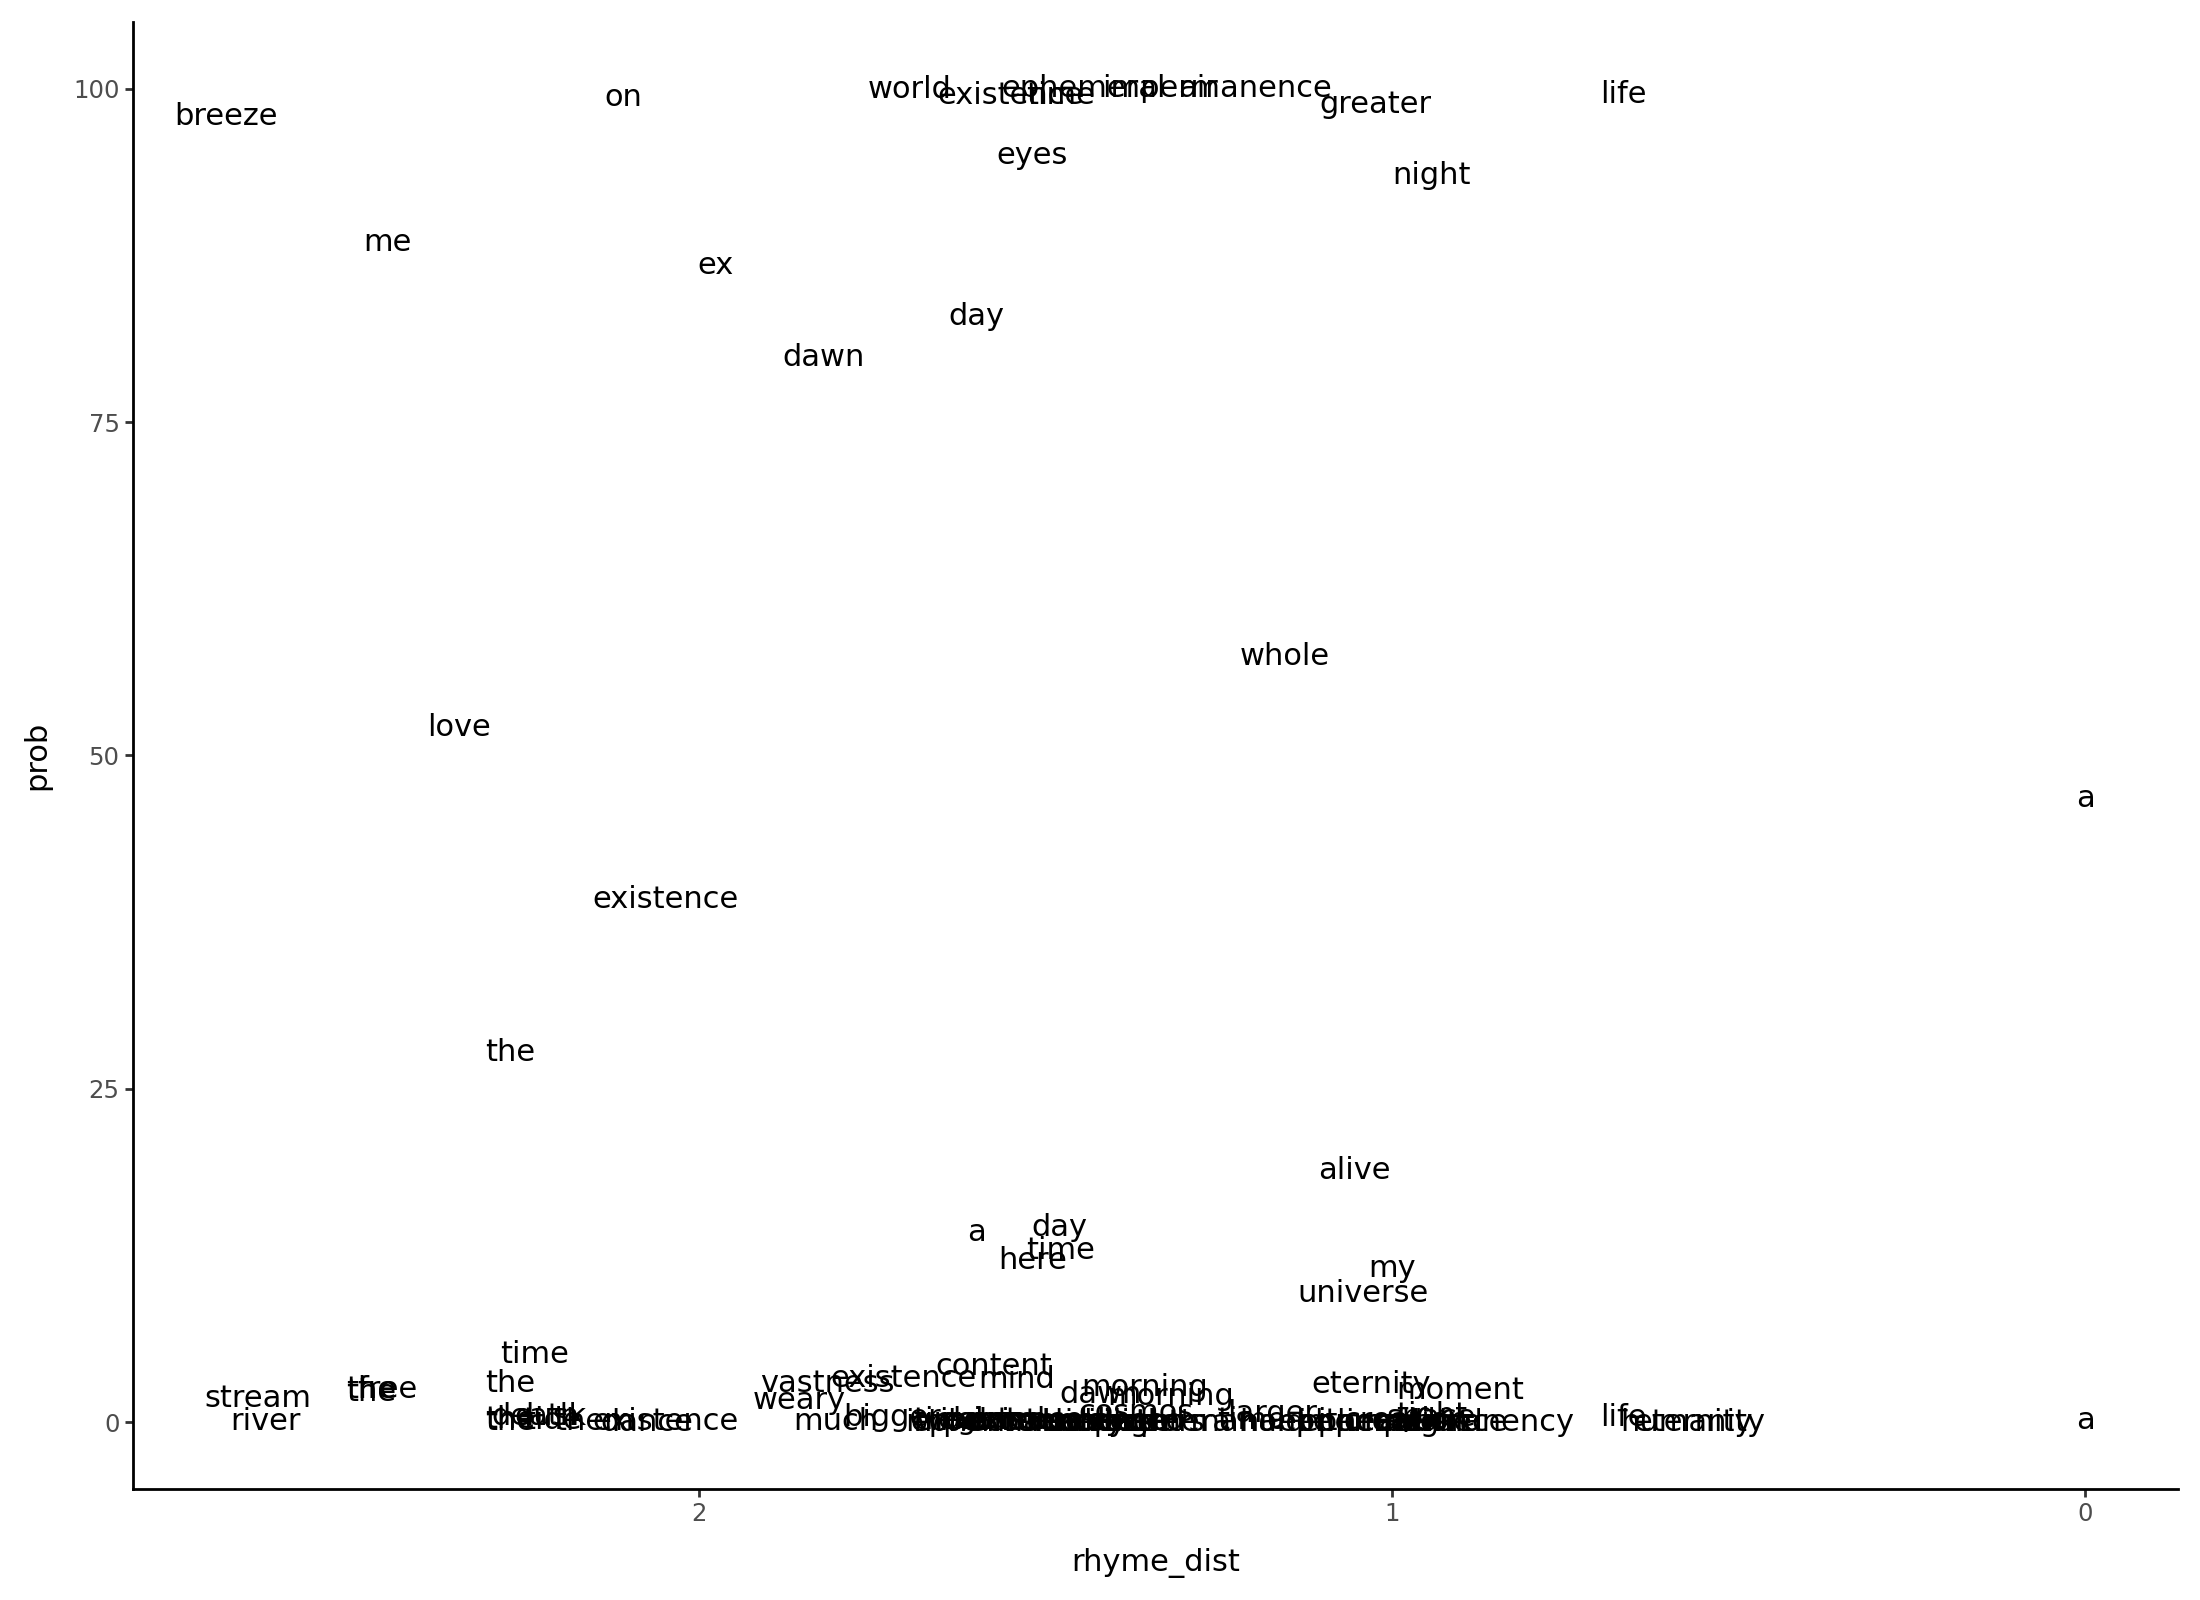

In [159]:
import plotnine as p9
p9.options.figure_size=11,8
fig=p9.ggplot(odf, p9.aes(x='rhyme_dist', y='prob', label='choice_str2'))
fig+=p9.geom_text()
fig+=p9.theme_classic()
fig+=p9.scale_x_reverse()
# fig+=p9.facet_wrap('line_i_word')
fig

In [60]:
df[df.token_i==160].to_dict(orient='records')

[{'line_i': 24,
  'token_i': 160,
  'token_str': 'more',
  'choice_i': 1,
  'choice_str': 'more',
  'logprob': -0.009937173,
  'prob': 99.0112037564092,
  'line_token_i': 5,
  'line_token_i_r': -1},
 {'line_i': 24,
  'token_i': 160,
  'token_str': 'more',
  'choice_i': 2,
  'choice_str': ' more',
  'logprob': -4.616478,
  'prob': 0.9887558790145988,
  'line_token_i': 5,
  'line_token_i_r': -1},
 {'line_i': 24,
  'token_i': 160,
  'token_str': 'more',
  'choice_i': 3,
  'choice_str': ',',
  'logprob': -16.05916,
  'prob': 1.0607069830661624e-05,
  'line_token_i': 5,
  'line_token_i_r': -1},
 {'line_i': 24,
  'token_i': 160,
  'token_str': 'more',
  'choice_i': 4,
  'choice_str': '-more',
  'logprob': -16.320387,
  'prob': 8.16856902793902e-06,
  'line_token_i': 5,
  'line_token_i_r': -1},
 {'line_i': 24,
  'token_i': 160,
  'token_str': 'more',
  'choice_i': 5,
  'choice_str': '.',
  'logprob': -16.553637,
  'prob': 6.469143657969858e-06,
  'line_token_i': 5,
  'line_token_i_r': -1}]